In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import L_sun

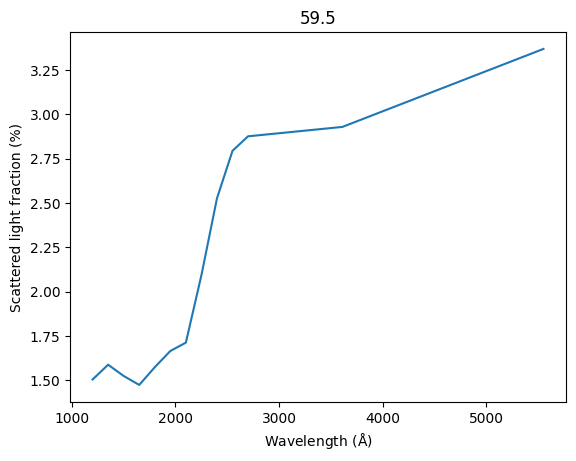

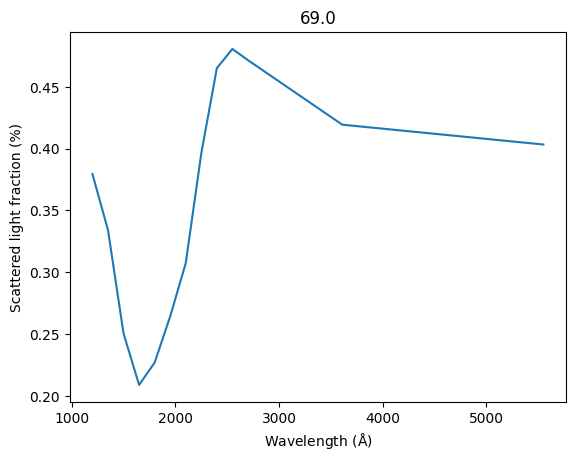

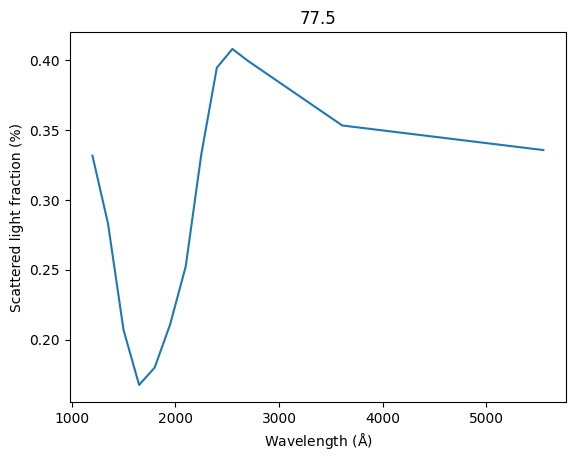

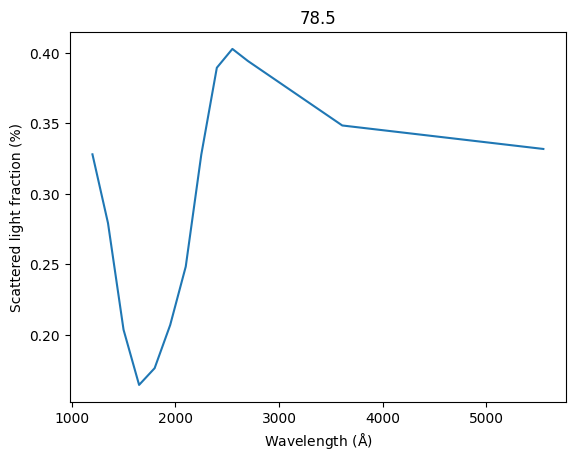

In [3]:
etas = np.array([59.5, 69.0, 77.5, 78.5])
for eta in etas:
    data = np.loadtxt("bHDPol_mrn77_tor_oa59.0_con_oa35.0-tauV0.1_i{}_sed.dat".format(eta))
    plt.plot(data[:,0]*1e4, data[:,1]/data[:,2] * 100)
    plt.ylabel('Scattered light fraction (%)')
    plt.xlabel(r'Wavelength ($\rm \AA$)')
    plt.title(eta)
    plt.show()

In [ ]:
plt.plot(data[:,0], data[:,1])
plt.plot(data[:,0], data[:,2])
plt.yscale('log')
plt.show()

In [ ]:
plt.plot(data[:,0]*1e4, data[:,1]/data[:,2] * 100)
plt.ylabel('Scattered light fraction (%)')
plt.xlabel(r'Wavelength ($\rm \AA$)')
plt.show()

In [13]:
class AGNModel(object):

    def __init__(self, Lbol=1e12*u.Lsun, D=10*u.Mpc):

        #Save the input parameter.
        self.Lbol = Lbol

        #Set the shape of the SED from https://skirt.ugent.be/skirt9/class_quasar_s_e_d.html
        self.AGN_model = list()
        self.AGN_model.append({'pl_coeff': 1./5., 'lam_min':0.001, 'lam_max':0.01 })
        self.AGN_model.append({'pl_coeff':-1.   , 'lam_min':0.01 , 'lam_max':0.1  })
        self.AGN_model.append({'pl_coeff':-3./2., 'lam_min':0.1  , 'lam_max':5.0  })
        self.AGN_model.append({'pl_coeff':-4.   , 'lam_min':5.0  , 'lam_max':1000.})

        #Get the normalization constants for each section. 
        for i,comp in enumerate(self.AGN_model):
            lam = np.logspace(np.log10(comp['lam_min']), np.log10(comp['lam_max']), 50, base=10.0)
            flam = lam**comp['pl_coeff']
            if i==0:
                norm = 1.0
            else:
                norm = flam_old[-1]/flam[0]
            flam_old = norm*flam
            self.AGN_model[i]['norm'] = norm
        
        #Normalize to the requested luminosity and distance. 
        SED_integral = 0
        for i, comp in enumerate(self.AGN_model):
            if comp['pl_coeff']!=-1.:
                alpha = comp['pl_coeff']+1
                SED_integral += comp['norm']/alpha * (comp['lam_max']**alpha - comp['lam_min']**alpha)
            else:
                SED_integral += comp['norm']*np.log(comp['lam_max']/comp['lam_min'])
        lum_factor = (Lbol/SED_integral) * (1./(4.*np.pi*D**2)) * (1./u.um)
        for i, comp in enumerate(self.AGN_model):
            self.AGN_model[i]['norm'] = self.AGN_model[i]['norm']*lum_factor.to(u.W/u.m**2/u.um)
        
        return
    
    def S_lam(self, wave):
        wave_use = wave.to(u.um).value
        norm = np.zeros(wave_use.shape)*self.AGN_model[0]['norm'].unit
        alpha = np.zeros(wave_use.shape)
        for comp in self.AGN_model:
            cond = (wave_use>=comp['lam_min']) & (wave_use<=comp['lam_max'])
            norm[cond] = comp['norm']
            alpha[cond] = comp['pl_coeff']
        return norm*(wave_use)**alpha 

In [ ]:
AGN = AGNModel(Lbol=1e12*L_sun, D=10*u.Mpc)
flam_tot = AGN.S_lam(data[:,0]*u.micron)
plt.plot(data[:,0]*1e4, data[:,1]/flam_tot * 100)
plt.ylabel('Scattered light fraction (%)')
plt.xlabel(r'Wavelength ($\rm \AA$)')
plt.show()